# Импорт

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, RocCurveDisplay, auc

import joblib


# Загружаем датасет и разбиваем её на выборку.

In [2]:
data = pd.read_csv('../Data/data_for_train.csv')
X_train, X_test, y_train, y_test = train_test_split(data.drop('hazardous', axis=1), data['hazardous'], test_size=0.25, random_state=42)
X_train.shape


(119916, 4)

In [3]:
data

,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,0.000407,0.235700,0.013606,0.703796,False
1,0.000789,0.032354,0.436880,0.645390,False
2,0.001450,0.232505,0.874154,0.591156,False
3,0.000492,0.174537,0.168484,0.687109,False
4,0.003665,0.284797,0.953300,0.507718,False
...,...,...,...,...,...
159883,0.003280,0.235111,0.653742,0.517827,True
159884,0.005284,0.187180,0.835387,0.474710,True
159885,0.030842,0.336628,0.813528,0.316302,True
159886,0.003190,0.102034,0.726150,0.520234,True


# Подбираем гиппер-параметры.

In [4]:
decision_tree_classifier_optimal_params = GridSearchCV(DecisionTreeClassifier(), 
                                                       {
                                                        'criterion': ["gini", "entropy", "log_loss"],
                                                        'max_depth': np.array(range(1, 2*X_train.shape[1]+1)),
                                                        # 'min_samples_split': np.array(range(2, X_train.shape[0]//2))
                                                        },
                                                        cv=2,
                                                        n_jobs=3,
                                                        scoring='accuracy'
                                            ).fit(X_train, y_train)
decision_tree_classifier_optimal_params.best_params_

{'criterion': 'gini', 'max_depth': 8}

# Обучение

In [5]:
decision_tree_classifier = DecisionTreeClassifier(
    criterion=decision_tree_classifier_optimal_params.best_params_['criterion'] if 'criterion' in decision_tree_classifier_optimal_params.best_params_ else 'gini',
    max_depth=decision_tree_classifier_optimal_params.best_params_['max_depth'] if 'max_depth' in decision_tree_classifier_optimal_params.best_params_ else None,
    )
decision_tree_classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8)

In [6]:
print(tree.export_text(decision_tree_classifier))

|--- feature_0 <= 0.00
|   |--- feature_0 <= 0.00
|   |   |--- feature_0 <= 0.00
|   |   |   |--- feature_3 <= 0.55
|   |   |   |   |--- feature_2 <= 0.91
|   |   |   |   |   |--- class: False
|   |   |   |   |--- feature_2 >  0.91
|   |   |   |   |   |--- feature_2 <= 0.91
|   |   |   |   |   |   |--- class: True
|   |   |   |   |   |--- feature_2 >  0.91
|   |   |   |   |   |   |--- class: False
|   |   |   |--- feature_3 >  0.55
|   |   |   |   |--- class: False
|   |   |--- feature_0 >  0.00
|   |   |   |--- feature_3 <= 0.55
|   |   |   |   |--- feature_2 <= 0.20
|   |   |   |   |   |--- feature_2 <= 0.20
|   |   |   |   |   |   |--- feature_1 <= 0.22
|   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |--- feature_1 >  0.22
|   |   |   |   |   |   |   |--- feature_1 <= 0.22
|   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |--- feature_1 >  0.22
|   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |--- feature_2 >  0.2

In [7]:
plt.figure(figsize=(200,50))
tree.plot_tree(decision_tree_classifier, feature_names='hazardous', filled=True)

[Text(0.3349319306930693, 0.9444444444444444, 'h <= 0.003\ngini = 0.5\nsamples = 119916\nvalue = [60093, 59823]'),
 Text(0.12670173267326731, 0.8333333333333334, 'h <= 0.003\ngini = 0.006\nsamples = 45116\nvalue = [44979, 137]'),
 Text(0.03217821782178218, 0.7222222222222222, 'h <= 0.002\ngini = 0.001\nsamples = 44324\nvalue = [44307, 17]'),
 Text(0.01485148514851485, 0.6111111111111112, 'a <= 0.55\ngini = 0.0\nsamples = 42895\nvalue = [42894, 1]'),
 Text(0.009900990099009901, 0.5, 'z <= 0.912\ngini = 0.004\nsamples = 559\nvalue = [558, 1]'),
 Text(0.0049504950495049506, 0.3888888888888889, 'gini = 0.0\nsamples = 510\nvalue = [510, 0]'),
 Text(0.01485148514851485, 0.3888888888888889, 'z <= 0.914\ngini = 0.04\nsamples = 49\nvalue = [48, 1]'),
 Text(0.009900990099009901, 0.2777777777777778, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.019801980198019802, 0.2777777777777778, 'gini = 0.0\nsamples = 48\nvalue = [48, 0]'),
 Text(0.019801980198019802, 0.5, 'gini = 0.0\nsamples = 42336\

## Оценка качества 

In [8]:
y_predicted = decision_tree_classifier.predict(X_test)
y_predicted

array([ True,  True,  True, ...,  True,  True,  True])

In [9]:
print('Accuracy')
print(accuracy_score(y_test, y_predicted))

Accuracy
0.8834934454117882


In [10]:
print('Confusion matrix')
print(confusion_matrix(y_test, y_predicted))

Confusion matrix
[[15354  4497]
 [  160 19961]]


In [11]:
print('Precision, Recall, F\n', classification_report(y_test, y_predicted))

Precision, Recall, F
               precision    recall  f1-score   support

       False       0.99      0.77      0.87     19851
        True       0.82      0.99      0.90     20121

    accuracy                           0.88     39972
   macro avg       0.90      0.88      0.88     39972
weighted avg       0.90      0.88      0.88     39972



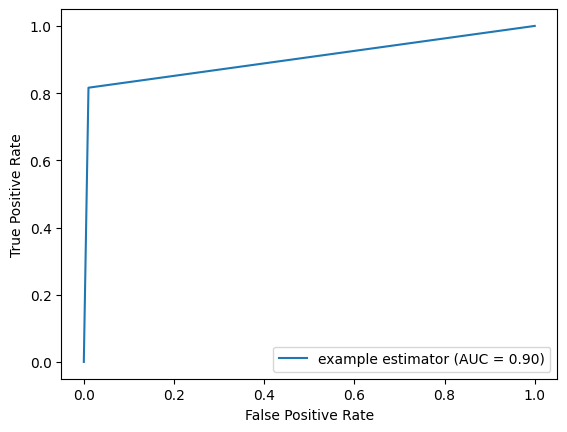

In [12]:
fpr, tpr, thresholds = roc_curve(y_predicted, y_test)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()

In [13]:
with open('../Models/CartTree.sav', 'wb') as handle:
    b = joblib.dump(decision_tree_classifier, handle)
